In [1]:
import numpy as np
import pandas as pd
import altair as alt

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# import lightgbm as lgb

from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from sklearn.svm import SVC

# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

In [2]:
# Load train and test dataset
train_df = pd.read_csv('../data/preprocessed/train.csv')
test_df = pd.read_csv('../data/preprocessed/test.csv')

In [3]:
X_train = train_df.drop(columns=['TARGET', 'random'])
y_train = train_df['TARGET']

X_test = test_df.drop(columns=['TARGET', 'random'])
y_test = test_df['TARGET']

In [4]:
y_train.value_counts(normalize=True)

0    0.875625
1    0.124375
Name: TARGET, dtype: float64

#### Scoring Metrics

Since this is an classification problem, the standard scoring metrics accuracy and apart from that, as we know from EDA that there is some class imbalance involved in the data, so it makes sense to look at scoring metrics like Precision, Recall and F1 score. To evaluate the performance of the model, i will also be looking at the Precision-Recall curve.

In [5]:
scoring_metrics = {
    "accuracy",
    "f1",
    "precision",
    "recall"
}

In [6]:
# Adapted from Lecture notes
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

#### Baseline Model 

In [7]:
model = DummyClassifier()
model.fit(X_train, y_train)


mean_std_cross_val_scores(model, X_train, y_train, scoring=scoring_metrics)

C:\Users\hp\miniconda3\envs\563\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\miniconda3\envs\563\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\miniconda3\envs\563\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\miniconda3\envs\563\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

fit_time          0.015 (+/- 0.011)
score_time        0.015 (+/- 0.004)
test_f1           0.000 (+/- 0.000)
test_accuracy     0.876 (+/- 0.000)
test_precision    0.000 (+/- 0.000)
test_recall       0.000 (+/- 0.000)
dtype: object

As expected, the result of baseline model is giving very high accuracy but precision, recall and f1 is 0

#### Preprocessing columns

In [8]:
numeric_cols = ['BALANCE',
                 'SCR',
                 'HOLDING_PERIOD',
                 'LEN_OF_RLTN_IN_MNTH',
                 'NO_OF_L_CR_TXNS',
                 'NO_OF_L_DR_TXNS',
                 'TOT_NO_OF_L_TXNS',
                 'NO_OF_BR_CSH_WDL_DR_TXNS',
                 'NO_OF_ATM_DR_TXNS',
                 'NO_OF_NET_DR_TXNS',
                 'NO_OF_MOB_DR_TXNS',
                 'NO_OF_CHQ_DR_TXNS',
                 'AMT_ATM_DR',
                 'AMT_BR_CSH_WDL_DR',
                 'AMT_CHQ_DR',
                 'AMT_NET_DR',
                 'AMT_MOB_DR',
                 'AMT_L_DR',
                 'AMT_OTH_BK_ATM_USG_CHGS',
                 'AMT_MIN_BAL_NMC_CHGS',
                 'AVG_AMT_PER_ATM_TXN',
                 'AVG_AMT_PER_CSH_WDL_TXN',
                 'AVG_AMT_PER_CHQ_TXN',
                 'AVG_AMT_PER_NET_TXN',
                 'AVG_AMT_PER_MOB_TXN'
                ]


numeric_cols_remove_collinear = ['BALANCE',
                                 'SCR',
                                 'HOLDING_PERIOD',
                                 'LEN_OF_RLTN_IN_MNTH',
                                 'NO_OF_L_CR_TXNS',
                                 'NO_OF_L_DR_TXNS',
                                 'AMT_OTH_BK_ATM_USG_CHGS',
                                 'AMT_MIN_BAL_NMC_CHGS',
                                 'AVG_AMT_PER_ATM_TXN',
                                 'AVG_AMT_PER_CSH_WDL_TXN',
                                 'AVG_AMT_PER_CHQ_TXN',
                                 'AVG_AMT_PER_NET_TXN',
                                 'AVG_AMT_PER_MOB_TXN'
                                ]

categorical_cols = ['NO_OF_IW_CHQ_BNC_TXNS', 'NO_OF_OW_CHQ_BNC_TXNS', 'AGE_BKT',
                    'GENDER', 'OCCUPATION', 'ACC_TYPE', 'FLG_HAS_CC',
                    'FLG_HAS_ANY_CHGS', 'FLG_HAS_NOMINEE', 'FLG_HAS_OLD_LOAN']

In [9]:
preprocessor = ColumnTransformer([
            ("scaling", StandardScaler(), numeric_cols),
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
])

In [10]:
preprocessor_remove_multicolinear = ColumnTransformer([
            ("scaling", StandardScaler(), numeric_cols_remove_collinear),
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
])

In [11]:
X_train_transformed = preprocessor_remove_multicolinear.fit_transform(X_train)
X_test_transformed = preprocessor_remove_multicolinear.transform(X_test)

onehotencode_feature_names = preprocessor_remove_multicolinear.named_transformers_['onehot'].get_feature_names_out().tolist()
feature_names = numeric_cols_remove_collinear + onehotencode_feature_names

X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

# Rename columns
X_train_transformed = X_train_transformed.rename(columns={'AGE_BKT_>50': 'AGE_BKT_GT_50',
                                                          'AGE_BKT_<25': 'AGE_BKT_LT_25'})

X_test_transformed = X_test_transformed.rename(columns={'AGE_BKT_>50': 'AGE_BKT_GT_50',
                                                        'AGE_BKT_<25': 'AGE_BKT_LT_25'})

##### Three problems to address in the dataset

1. **Multicollinearity** - To handle multicollinearity, I looked up into the input features in eda correlation plot and have extracted selected which have very low correlation 

    _Refer correlation plot of selected features below_

2.  **Class Imbalance** - To handle class imbalance, I have using class_weight = 'balanced' and SMOTE and see what works better.

3. **Large number of features** - There are total 38 features per example. Though this dataset is not considered high dimensional, we need to know if we need all 38 features.

# Detect multicollinearity in features

### Method - 1 (VIF- Variance Inflation factor)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
# VIF dataframe
vif_data = pd.DataFrame()
X = train_df[numeric_cols_remove_collinear]
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [16]:
vif_data

,feature,VIF
0,BALANCE,1.460184
1,SCR,3.391247
2,HOLDING_PERIOD,3.668257
3,LEN_OF_RLTN_IN_MNTH,4.545220
4,NO_OF_L_CR_TXNS,3.372208
5,NO_OF_L_DR_TXNS,6.241194
6,AMT_OTH_BK_ATM_USG_CHGS,1.892585
7,AMT_MIN_BAL_NMC_CHGS,1.011957
8,AVG_AMT_PER_ATM_TXN,2.473066
9,AVG_AMT_PER_CSH_WDL_TXN,1.762525


In [24]:
# from sklearn.decomposition import PCA
# pca_model = PCA(n_components = 22)
# pca_model.fit(X_train_transformed)

In [23]:
# sum(pca_model.explained_variance_ratio_)

##### _Correlation plot of selected features_

In [25]:
train_corr_selected_features = train_df[numeric_cols_remove_collinear].corr().stack().reset_index(name='corr')
train_corr_selected_features['corr'] = round(train_corr_selected_features['corr'], 2)

train_corr_selected_features_plot = (
    alt.Chart(train_corr_selected_features, title='Correlation plot of selected features')
       .encode(x=alt.X('level_0', title=''),
               y=alt.Y('level_1', title=''),
               color=alt.Color('corr', scale=alt.Scale(scheme='blueorange',
                                                       domain=(-1, 1))
                               , title='Pearson correlation'))
       .mark_rect()).properties(width=600, height=500
)

train_corr_selected_features_plot = train_corr_selected_features_plot + train_corr_selected_features_plot.mark_text(baseline='middle').encode(
    text='corr:Q',
    color=alt.value('black'))

train_corr_selected_features_plot

alt.LayerChart(...)

#### _Handle class imbalance with SMOTE and SMOTE + undersampling_

In [13]:
oversampling_with_smote = SMOTE()

# transform the dataset
X_smote, y_smote = oversampling_with_smote.fit_resample(X_train_transformed, y_train)

# define pipeline for SMOTE with undersampling
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_smote_under, y_smote_under = pipeline.fit_resample(X_train_transformed, y_train)

In [14]:
print(y_train.value_counts())
print(y_smote.value_counts())
print(y_smote_under.value_counts())

0    14010
1     1990
Name: TARGET, dtype: int64
0    14010
1    14010
Name: TARGET, dtype: int64
0    7005
1    4203
Name: TARGET, dtype: int64


In [15]:
results_linear_models = {}
results_tree_models = {}
results_non_linear_models = {}

#### Decision Tree Model 

In [16]:
# Model with class_weight = 'balanced'
model_decisiontree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123,
                                                                        class_weight='balanced'))
model_decisiontree.fit(X_train, y_train)

results_tree_models['DecisionTree'] = mean_std_cross_val_scores(model_decisiontree,
                                                                X_train,
                                                                y_train,
                                                                return_train_score=True,
                                                                scoring=scoring_metrics
                                                               )

# Use preprocessor without multicollinear features and class_weight = 'balanced'
model_decisiontree_selected_features = make_pipeline(preprocessor_remove_multicolinear, 
                                                     DecisionTreeClassifier(random_state=123, class_weight='balanced'))
model_decisiontree_selected_features.fit(X_train, y_train)

results_tree_models['DecisionTree_selected_features'] = mean_std_cross_val_scores(model_decisiontree_selected_features,
                                                                   X_train,
                                                                   y_train,
                                                                   return_train_score=True,
                                                                   scoring=scoring_metrics)


# Model with smote dataset
model_decisiontree_smote = DecisionTreeClassifier(random_state=123)
results_tree_models['DecisionTree_smote'] = mean_std_cross_val_scores(model_decisiontree_smote,
                                                                      X_smote,
                                                                      y_smote,
                                                                      return_train_score=True,
                                                                      scoring=scoring_metrics)

# Model with smote + undersample dataset
model_decisiontree_smote_under = DecisionTreeClassifier(random_state=123)
results_tree_models['DecisionTree_smote_undersampling'] = mean_std_cross_val_scores(model_decisiontree_smote_under,
                                                                            X_smote_under,
                                                                            y_smote_under,
                                                                            return_train_score=True,
                                                                            scoring=scoring_metrics)

In [17]:
pd.DataFrame(results_tree_models)

,DecisionTree,DecisionTree_selected_features,DecisionTree_smote,DecisionTree_smote_undersampling
fit_time,0.237 (+/- 0.031),0.137 (+/- 0.006),0.262 (+/- 0.019),0.084 (+/- 0.007)
score_time,0.018 (+/- 0.004),0.017 (+/- 0.002),0.006 (+/- 0.009),0.006 (+/- 0.009)
test_precision,0.708 (+/- 0.022),0.723 (+/- 0.027),0.942 (+/- 0.009),0.818 (+/- 0.012)
train_precision,1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_accuracy,0.930 (+/- 0.006),0.933 (+/- 0.006),0.947 (+/- 0.014),0.875 (+/- 0.019)
train_accuracy,1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_f1,0.727 (+/- 0.031),0.737 (+/- 0.025),0.947 (+/- 0.016),0.837 (+/- 0.028)
train_f1,1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_recall,0.747 (+/- 0.049),0.754 (+/- 0.040),0.954 (+/- 0.039),0.858 (+/- 0.049)
train_recall,1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


**Observations**:

1. Scores seems to be little improved after removing multicollinear features but the improvement cannot be termed as significant as Decision Tree classifiers are robust to multicolinearity. 

2. SMOTE is performed on selected features and seems to be providing the best scores though they are overfitted. 

3. The SMOTE + undersampling is observed to be performing better than handling imbalance with class_weight parameter even when the examples in SMOTE + undersampling is less than original sample.

In [18]:
model_lr = make_pipeline(preprocessor, LogisticRegression(random_state=123, max_iter=2000, 
                                                          class_weight='balanced'))
model_lr.fit(X_train, y_train)
results_linear_models['Logistic Regression'] = mean_std_cross_val_scores(model_lr, X_train, y_train,
                                                                        return_train_score=True, 
                                                                         scoring=scoring_metrics)


model_lr_selected_features = make_pipeline(preprocessor_remove_multicolinear, LogisticRegression(random_state=123, 
                                                                                  max_iter=2000, 
                                                                                  class_weight='balanced'))
model_lr_selected_features.fit(X_train, y_train)
results_linear_models['Logistic Regression selected features'] = mean_std_cross_val_scores(model_lr_selected_features,
                                                                            X_train,
                                                                            y_train,
                                                                            return_train_score=True,
                                                                            scoring=scoring_metrics)


model_lr_smote = LogisticRegression(random_state=123, max_iter=2000)
model_lr_smote.fit(X_smote, y_smote)
results_linear_models['Logistic Regression smote'] = mean_std_cross_val_scores(model_lr_smote,
                                                                               X_smote, 
                                                                               y_smote,
                                                                               return_train_score=True, 
                                                                               scoring=scoring_metrics)

model_lr_smote_under = LogisticRegression(random_state=123, max_iter=2000)
model_lr_smote_under.fit(X_smote_under, y_smote_under)
results_linear_models['Logistic Regression smote undersampling'] = mean_std_cross_val_scores(model_lr_smote_under,
                                                                                             X_smote_under, 
                                                                                             y_smote_under,
                                                                                             return_train_score=True,
                                                                                             scoring=scoring_metrics)

In [19]:
pd.DataFrame(results_linear_models)

,Logistic Regression,Logistic Regression selected features,Logistic Regression smote,Logistic Regression smote undersampling
fit_time,0.288 (+/- 0.028),0.165 (+/- 0.049),0.228 (+/- 0.053),0.053 (+/- 0.007)
score_time,0.016 (+/- 0.000),0.016 (+/- 0.000),0.013 (+/- 0.007),0.003 (+/- 0.007)
test_precision,0.214 (+/- 0.010),0.209 (+/- 0.008),0.660 (+/- 0.003),0.620 (+/- 0.020)
train_precision,0.218 (+/- 0.004),0.213 (+/- 0.003),0.661 (+/- 0.002),0.627 (+/- 0.004)
test_accuracy,0.665 (+/- 0.007),0.661 (+/- 0.005),0.656 (+/- 0.003),0.686 (+/- 0.008)
train_accuracy,0.669 (+/- 0.004),0.663 (+/- 0.004),0.657 (+/- 0.002),0.690 (+/- 0.002)
test_f1,0.319 (+/- 0.016),0.313 (+/- 0.012),0.651 (+/- 0.006),0.501 (+/- 0.016)
train_f1,0.325 (+/- 0.005),0.319 (+/- 0.004),0.652 (+/- 0.002),0.509 (+/- 0.004)
test_recall,0.632 (+/- 0.033),0.623 (+/- 0.027),0.643 (+/- 0.014),0.421 (+/- 0.023)
train_recall,0.641 (+/- 0.008),0.633 (+/- 0.004),0.644 (+/- 0.003),0.429 (+/- 0.006)


**Observations**:

Interesting to note that Logistic regression is sensitive to multicollinearity as one of it's assumption is that multicollineaity should not be present. But as I removed multicollinear features, the scores are decreasing as it might be possible that even though the features had correlation, they might be providing some information. 

Also, SMOTE seems to have worked better than class_weight parameter but SMOTE + undersampling performs poorly with logistic regression. This also confirms one of the assumption of logistic regression that sample size should be large enough. 


**Key takeaway**:  
- What works for one model doesn't necessarily work for other. 
- Try different things and see what works best with your dataset.

In [20]:
model_svc = make_pipeline(preprocessor, SVC(random_state=123,
                                            class_weight='balanced'))
model_svc.fit(X_train, y_train)
results_non_linear_models['SVC'] = mean_std_cross_val_scores(model_svc, X_train, y_train,
                                                         return_train_score=True, 
                                                         scoring=scoring_metrics)


model_svc_selected_features = make_pipeline(preprocessor_remove_multicolinear, SVC(random_state=123,
                                                                    class_weight='balanced'))
model_svc_selected_features.fit(X_train, y_train)
results_non_linear_models['SVC_selected_features'] = mean_std_cross_val_scores(model_svc_selected_features, X_train, y_train,
                                                           return_train_score=True, 
                                                           scoring=scoring_metrics)


model_svc_smote = SVC(random_state=123)
model_svc_smote.fit(X_smote, y_smote)
results_non_linear_models['SVC_smote'] = mean_std_cross_val_scores(model_svc_smote, X_train_transformed, y_train,
                                                           return_train_score=True, 
                                                           scoring=scoring_metrics)

model_svc_smote_undersampling = SVC(random_state=123)
model_svc_smote_undersampling.fit(X_smote_under, y_smote_under)
results_non_linear_models['SVC_smote_undersampling'] = mean_std_cross_val_scores(model_svc_smote_undersampling, X_train_transformed, y_train,
                                                           return_train_score=True, 
                                                           scoring=scoring_metrics)

In [21]:
pd.DataFrame(results_non_linear_models)

,SVC,SVC_selected_features,SVC_smote,SVC_smote_undersampling
fit_time,8.643 (+/- 0.082),7.859 (+/- 0.118),4.506 (+/- 0.028),4.342 (+/- 0.110)
score_time,3.096 (+/- 0.103),2.855 (+/- 0.076),1.447 (+/- 0.034),1.364 (+/- 0.058)
test_precision,0.315 (+/- 0.011),0.311 (+/- 0.013),0.943 (+/- 0.056),0.943 (+/- 0.056)
train_precision,0.375 (+/- 0.003),0.377 (+/- 0.003),1.000 (+/- 0.000),1.000 (+/- 0.000)
test_accuracy,0.771 (+/- 0.008),0.767 (+/- 0.007),0.878 (+/- 0.001),0.878 (+/- 0.001)
train_accuracy,0.807 (+/- 0.002),0.806 (+/- 0.002),0.882 (+/- 0.001),0.882 (+/- 0.001)
test_f1,0.438 (+/- 0.014),0.434 (+/- 0.018),0.047 (+/- 0.011),0.047 (+/- 0.011)
train_f1,0.516 (+/- 0.004),0.522 (+/- 0.003),0.096 (+/- 0.010),0.096 (+/- 0.010)
test_recall,0.718 (+/- 0.026),0.718 (+/- 0.034),0.024 (+/- 0.006),0.024 (+/- 0.006)
train_recall,0.829 (+/- 0.008),0.851 (+/- 0.007),0.050 (+/- 0.005),0.050 (+/- 0.005)


**Observations**

Even though SVC with RBF kernel is non linear model , it is not able to capture the non-linear pattern. The SVC model is tested on default degree 3 only and the performance is very poor. SMOTE and SMOTE + undersampling doesn't seem to work with SVC model (and this confirms that some things work for some models only). 

Also, the fit and score time for SVC is way higher than the decision tree model, so it can be said that decision tree has performed well out of 3 models.

But we still have overfitting issue with decision tree and hence we need to look more into tree based models to handle it.

### Bagging (RandomForest)

In [22]:
model_RF = RandomForestClassifier()
model_RF.fit(X_smote_under, y_smote_under)

results_tree_models['RandomForest'] = mean_std_cross_val_scores(model_RF,
                                                               X_smote_under,
                                                               y_smote_under,
                                                               return_train_score=True,
                                                               scoring=scoring_metrics)

### Boosting (XGBoost and LightGBM)

In [23]:
model_xgb = XGBClassifier(use_label_encoder =False, 
                          verbosity=0)
model_xgb.fit(X_smote_under, y_smote_under)
results_tree_models['XGBboost'] = mean_std_cross_val_scores(model_xgb,
                                                           X_smote_under,
                                                           y_smote_under,
                                                           return_train_score=True,
                                                           scoring=scoring_metrics)


model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_smote_under, y_smote_under)
results_tree_models['LightGBM'] = mean_std_cross_val_scores(model_lgb,
                                                           X_smote_under,
                                                           y_smote_under,
                                                           return_train_score=True,
                                                           scoring=scoring_metrics)

In [24]:
pd.DataFrame(results_tree_models)

,DecisionTree,DecisionTree_selected_features,DecisionTree_smote,DecisionTree_smote_undersampling,RandomForest,XGBboost,LightGBM
fit_time,0.237 (+/- 0.031),0.137 (+/- 0.006),0.262 (+/- 0.019),0.084 (+/- 0.007),1.212 (+/- 0.018),0.551 (+/- 0.007),0.163 (+/- 0.013)
score_time,0.018 (+/- 0.004),0.017 (+/- 0.002),0.006 (+/- 0.009),0.006 (+/- 0.009),0.046 (+/- 0.002),0.000 (+/- 0.001),0.010 (+/- 0.009)
test_precision,0.708 (+/- 0.022),0.723 (+/- 0.027),0.942 (+/- 0.009),0.818 (+/- 0.012),0.974 (+/- 0.004),0.929 (+/- 0.006),0.924 (+/- 0.008)
train_precision,1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.999 (+/- 0.001),0.985 (+/- 0.007)
test_accuracy,0.930 (+/- 0.006),0.933 (+/- 0.006),0.947 (+/- 0.014),0.875 (+/- 0.019),0.945 (+/- 0.041),0.929 (+/- 0.042),0.895 (+/- 0.063)
train_accuracy,1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.992 (+/- 0.003),0.950 (+/- 0.007)
test_f1,0.727 (+/- 0.031),0.737 (+/- 0.025),0.947 (+/- 0.016),0.837 (+/- 0.028),0.920 (+/- 0.063),0.900 (+/- 0.065),0.839 (+/- 0.110)
train_f1,1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.990 (+/- 0.004),0.929 (+/- 0.009)
test_recall,0.747 (+/- 0.049),0.754 (+/- 0.040),0.954 (+/- 0.039),0.858 (+/- 0.049),0.877 (+/- 0.112),0.879 (+/- 0.117),0.783 (+/- 0.180)
train_recall,1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.981 (+/- 0.007),0.880 (+/- 0.012)


It can be observed that Random Forest is performing better than boosting algorithms which makes sense as well as bagging algorithms helps to reduce bias and not variance and hence bagging algo (Random Forest) can be considered best to tackle overfitting problem.

In [25]:
X_train_transformed.shape

(16000, 43)

In [26]:
param_dist = {'max_depth': np.linspace(1, 20, 20),
              'n_estimators': np.arange(5, 50, 5)}

In [27]:
param_dist

{'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])}

In [28]:
random_search = RandomizedSearchCV(model_RF, param_distributions=param_dist,
                                  scoring=scoring_metrics,
                                  n_jobs=-1,
                                  return_train_score=True,
                                  random_state=123,
                                  refit='f1')

In [29]:
random_search.fit(X_smote_under, y_smote_under)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.]),
                                        'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])},
                   random_state=123, refit='f1', return_train_score=True,
                   scoring={'precision', 'accuracy', 'f1', 'recall'})

In [30]:
random_search.best_estimator_

RandomForestClassifier(max_depth=20.0, n_estimators=30)

In [31]:
model_rf_hyperparameter = RandomForestClassifier(max_depth=random_search.best_estimator_.max_depth,
                                                 n_estimators=random_search.best_estimator_.n_estimators,
                                                 random_state=123)
mean_std_cross_val_scores(model_rf_hyperparameter, X_smote_under, y_smote_under,
                          return_train_score=True,
                          scoring=scoring_metrics)

fit_time           0.316 (+/- 0.012)
score_time         0.016 (+/- 0.001)
test_precision     0.960 (+/- 0.009)
train_precision    1.000 (+/- 0.000)
test_accuracy      0.940 (+/- 0.039)
train_accuracy     0.999 (+/- 0.000)
test_f1            0.914 (+/- 0.059)
train_f1           0.999 (+/- 0.000)
test_recall        0.877 (+/- 0.101)
train_recall       0.999 (+/- 0.001)
dtype: object

In [32]:
random_search.best_score_

0.9142276074505465

In [33]:
model_rf_hyperparameter.fit(X_smote_under, y_smote_under)

RandomForestClassifier(max_depth=20.0, n_estimators=30, random_state=123)

In [34]:
y_pred = model_rf_hyperparameter.predict(X_test_transformed,)
y_scores = model_rf_hyperparameter.predict_proba(X_test_transformed)

### Confusion Matrix

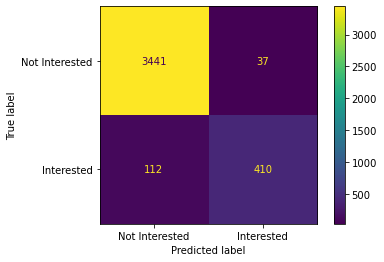

In [35]:
cm = confusion_matrix(y_test, y_pred, labels=model_rf_hyperparameter.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Not Interested', 'Interested'])
disp.plot()

> #### The confusion matrix obtained tells us that we are predicting 69 customers as interested when they are not and neglecting 121 customers which are interested as Not Interested. The range of acceptable mistakes by model entirely depends on the business, use-case, investments etc.

> #### The default threshold chosen is 0.5 and have 121 False Negatives (Type II error) and 69 False Positives (Type I error). Based on the business needs, the threshold can be set to lower, False Positives would increase and larger not interested customer base would be targeted. If set to higher, then more False negatives then we would loose on lot of interested customers.

### Precision - Recall curve 

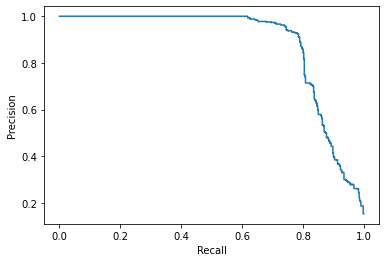

In [36]:
prec, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1], pos_label=model_rf_hyperparameter.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

#### Interesting to see that precision is constant for all thresholds except the extreme cases.

### Threshold can be set to see the impact on model predictions.

In [37]:
threshold = 0.6
y_pred_threshold = (y_scores[:, 1] > threshold).astype('int')
y_pred_threshold

array([0, 0, 0, ..., 0, 0, 0])

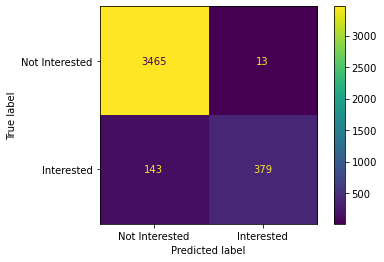

In [38]:
cm_threshold = confusion_matrix(y_test, y_pred_threshold, labels=model_rf_hyperparameter.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_threshold,
                               display_labels=['Not Interested', 'Interested'])
disp.plot()